<a href="https://colab.research.google.com/github/andrewsiefert/nba_prediction/blob/master/NBA_game_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

In [ ]:
import numpy as np
import pandas as pd
from google.colab import files
import io
import datetime

## Upload game data

In [ ]:
uploaded = files.upload()

Saving games.csv to games.csv


In [ ]:
games = pd.read_csv(io.BytesIO(uploaded['games.csv']), parse_dates = ['start_time']).drop('Unnamed: 0', axis = 1)
games = games.loc[games.season > 2015]
games.head()

,away_team,away_team_score,home_team,home_team_score,season,start_time
7641,detroit_pistons,106,atlanta_hawks,94,2016,2015-10-28 00:00:00+00:00
7642,cleveland_cavaliers,95,chicago_bulls,97,2016,2015-10-28 00:00:00+00:00
7643,new_orleans_pelicans,95,golden_state_warriors,111,2016,2015-10-28 02:30:00+00:00
7644,philadelphia_76ers,95,boston_celtics,112,2016,2015-10-28 23:30:00+00:00
7645,chicago_bulls,115,brooklyn_nets,100,2016,2015-10-28 23:30:00+00:00


## Data prep

### Get game day of year

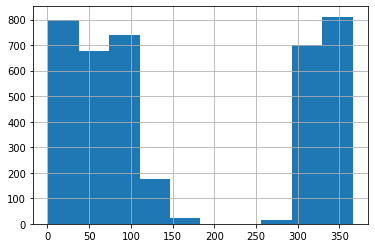

In [ ]:
games['start_day'] = games['start_time'].dt.dayofyear
games.start_day.hist()

### Normalize scores

In [ ]:
from sklearn import preprocessing

scores = games[['away_team_score', 'home_team_score']]
min_max_scaler = preprocessing.MinMaxScaler()
scaled_scores = min_max_scaler.fit_transform(scores)
games['away_team_score_scaled'] = scaled_scores[:,0]
games['home_team_score_scaled'] = scaled_scores[:,1]

### Create one row per team per game

In [ ]:
teams = games['home_team'].unique().tolist()

all_games = pd.DataFrame()

for team in teams:
    
    # make rows for team's home games
    home_games = games[games['home_team']==team]
    home_games.rename(index = str, columns = {'home_team':'team', 'away_team':'opponent', 'home_team_score':'score', 'away_team_score':'opponent_score'}, inplace = True)
    home_games['home'] = 1

    # make rows for team's away games
    away_games = games[games['away_team']==team]
    away_games.rename(index = str, columns = {'away_team':'team', 'home_team':'opponent', 'away_team_score':'score', 'home_team_score':'opponent_score'}, inplace = True)
    away_games['home'] = 0

    # combine home and away games
    g = pd.concat([home_games, away_games], join = "inner").sort_values('start_time')

    # get game of season
    g['game'] = g.groupby('season')['season'].transform(lambda x: np.arange(1, len(x)+1))

    # get game outcomes (1 = win, 0 = loss)
    g['outcome'] = ((g.score - g.opponent_score) > 0).astype('int')

    # get team's rest days
    g['rest'] = (g.start_time - g.start_time.shift(periods = 1)).dt.total_seconds() / (24 * 60 * 60)
    g.loc[g.game == 1, 'rest'] = np.NaN

    # get team's point differential and wins/losses
    g['margin'] = g.score - g.opponent_score
    g['point_diff_sum'] = g.groupby('season', group_keys = False).apply(lambda x: x['margin'].cumsum().shift(periods = 1))
    g['point_diff'] = g.point_diff_sum / (g.game-1)
    g['wins'] = g.groupby('season', group_keys = False).apply(lambda x: x['outcome'].cumsum().shift(periods = 1))
    g['losses'] = g.game - g.wins - 1
    g['winning_pct'] = g['wins']/(g['game'] - 1)
    
    # append team's games to all games data frame
    all_games = all_games.append(g, ignore_index = True)
    

In [107]:
# winning percentages
print(all_games.shape)
print(all_games.groupby('team')['outcome'].mean().sort_values(ascending = False))

(7874, 24)
team
golden_state_warriors     0.795455
san_antonio_spurs         0.685921
cleveland_cavaliers       0.648208
toronto_raptors           0.643357
houston_rockets           0.641577
boston_celtics            0.615917
oklahoma_city_thunder     0.596364
los_angeles_clippers      0.583012
utah_jazz                 0.552239
washington_wizards        0.535849
indiana_pacers            0.534091
miami_heat                0.532075
portland_trail_blazers    0.524528
charlotte_hornets         0.486166
denver_nuggets            0.483740
detroit_pistons           0.480000
milwaukee_bucks           0.478764
atlanta_hawks             0.461832
new_orleans_pelicans      0.458824
chicago_bulls             0.444444
minnesota_timberwolves    0.430279
memphis_grizzlies         0.425781
dallas_mavericks          0.398406
new_york_knicks           0.373984
sacramento_kings          0.373984
philadelphia_76ers        0.371094
orlando_magic             0.361789
los_angeles_lakers        0.317073
broo

### Add opponent info

In [ ]:
all_games.loc[:, 'opponent_point_diff'] = np.NaN
all_games.loc[:, 'opponent_wins']= np.NaN
all_games.loc[:, 'opponent_losses']= np.NaN
all_games.loc[:, 'opponent_win_pct']= np.NaN
all_games.loc[:, 'opponent_rest']= np.NaN

for ind, g in all_games.iterrows():
  opponent = all_games.loc[(all_games.team == g.opponent) & (all_games.start_time == g.start_time),:]
  all_games.at[ind, 'opponent_point_diff'] = opponent['point_diff']
  all_games.at[ind, 'opponent_wins'] = opponent['wins']
  all_games.at[ind, 'opponent_losses'] = opponent['losses']
  all_games.at[ind, 'opponent_win_pct'] = opponent['winning_pct']
  all_games.at[ind, 'opponent_rest'] = opponent['rest']

all_games = all_games.fillna(0)
all_games.head()

,opponent,opponent_score,team,score,season,start_time,start_day,away_team_score_scaled,home_team_score_scaled,home,game,outcome,rest,margin,point_diff_sum,point_diff,wins,losses,winning_pct,opponent_point_diff,opponent_wins,opponent_losses,opponent_win_pct,opponent_rest
0,detroit_pistons,106,atlanta_hawks,94,2016,2015-10-28 00:00:00+00:00,301,0.475,0.352941,1,1,0,0.000000,-12,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,new_york_knicks,101,atlanta_hawks,112,2016,2015-10-30 00:00:00+00:00,303,0.550,0.435294,0,2,1,2.000000,11,-12.0,-12.000000,0.0,1.0,0.000000,25.000000,1.0,0.0,1.000000,1.000000
2,charlotte_hornets,94,atlanta_hawks,97,2016,2015-10-31 00:00:00+00:00,304,0.325,0.388235,1,3,1,1.000000,3,-1.0,-0.500000,1.0,1.0,0.500000,-10.000000,0.0,1.0,0.000000,2.020833
3,charlotte_hornets,92,atlanta_hawks,94,2016,2015-11-01 19:00:00+00:00,305,0.325,0.329412,0,4,1,1.791667,2,2.0,0.666667,2.0,1.0,0.666667,-6.500000,0.0,2.0,0.000000,1.791667
4,miami_heat,92,atlanta_hawks,98,2016,2015-11-04 00:30:00+00:00,308,0.375,0.329412,0,5,1,2.229167,6,4.0,1.000000,3.0,1.0,0.750000,6.666667,2.0,1.0,0.666667,2.062500


### Standardize features

In [ ]:
from sklearn.preprocessing import StandardScaler

z_scaler = StandardScaler()

features = ['score', 'opponent_score', 'home', 'rest', 'opponent_rest', 'opponent_point_diff', 'opponent_win_pct'] 

all_games_scaled = all_games.copy()
all_games_scaled[features] = z_scaler.fit_transform(all_games_scaled[features])

all_games_scaled.head()

,opponent,opponent_score,team,score,season,start_time,start_day,away_team_score_scaled,home_team_score_scaled,home,game,outcome,rest,margin,point_diff_sum,point_diff,wins,losses,winning_pct,opponent_point_diff,opponent_wins,opponent_losses,opponent_win_pct,opponent_rest
0,detroit_pistons,0.101490,atlanta_hawks,-0.888656,2016,2015-10-28 00:00:00+00:00,301,0.475,0.352941,1.0,1,0,-2.006727,-12,0.0,0.000000,0.0,0.0,0.000000,-0.049082,0.0,0.0,-2.660584,-2.006727
1,new_york_knicks,-0.311071,atlanta_hawks,0.596563,2016,2015-10-30 00:00:00+00:00,303,0.550,0.435294,-1.0,2,1,-0.108667,11,-12.0,-12.000000,0.0,1.0,0.000000,4.460406,1.0,0.0,2.624286,-1.057697
2,charlotte_hornets,-0.888656,atlanta_hawks,-0.641120,2016,2015-10-31 00:00:00+00:00,304,0.325,0.388235,1.0,3,1,-1.057697,3,-1.0,-0.500000,1.0,1.0,0.500000,-1.852877,0.0,1.0,-2.660584,-0.088896
3,charlotte_hornets,-1.053681,atlanta_hawks,-0.888656,2016,2015-11-01 19:00:00+00:00,305,0.325,0.329412,-1.0,4,1,-0.306382,2,2.0,0.666667,2.0,1.0,0.666667,-1.221549,0.0,2.0,-2.660584,-0.306382
4,miami_heat,-1.053681,atlanta_hawks,-0.558608,2016,2015-11-04 00:30:00+00:00,308,0.375,0.329412,-1.0,5,1,0.108818,6,4.0,1.000000,3.0,1.0,0.750000,1.153448,2.0,1.0,0.862663,-0.049353


### Create training sequences (last 20 games)

In [ ]:
# create training data (home and away team sequences: n games x sequence length (last 20 games) x features (score, opponent score, home/away)
train_games = games.loc[games.start_day < 200].reset_index()

n = train_games.shape[0]
seq_len = 20
n_features = len(features)
X_home = np.zeros((n, seq_len, n_features), dtype = float)
X_away = np.zeros((n, seq_len, n_features), dtype = float)
y = np.zeros((n, 1))

for index, game in train_games.iterrows():
    
  home_games = all_games_scaled.loc[(all_games_scaled.team == game.home_team) & (all_games_scaled.season== game.season) & (all_games_scaled.start_time <= game.start_time),:].iloc[-(seq_len+1):-1,:]
  home_seq = np.zeros((seq_len, n_features))
  for i in range(0, home_games.shape[0]):
    home_seq[i] = home_games.iloc[i,:][features].tolist()
    
  away_games = all_games_scaled.loc[(all_games_scaled.team == game.away_team) & (all_games_scaled.season== game.season) & (all_games_scaled.start_time <= game.start_time),:].iloc[-(seq_len+1):-1,:]
  away_seq = np.zeros((seq_len, n_features))
  for i in range(0, away_games.shape[0]):
    away_seq[i] = away_games.iloc[i,:][features].tolist()
    
  score = game.home_team_score - game.away_team_score
    
  X_home[index] = home_seq
  X_away[index] = away_seq
  y[index] = score


In [ ]:
print(X_home.shape)
print(X_away.shape)
print(len(y))

(2412, 20, 7)
(2412, 20, 7)
2412


In [ ]:
X_home[100, :, 0]

### Create training sequences (all games w/ zero padding)

In [ ]:
train_games = games.loc[games.start_day < 200].reset_index()
n = train_games.shape[0]
max_games = np.max(all_games.game)
X_home = np.zeros((n, max_games, n_features), dtype = float)
X_away = np.zeros((n, max_games, n_features), dtype = float)
y = np.zeros((n, 1))

for index, game in train_games.iterrows():
    
    home_games = all_games_scaled.loc[(all_games_scaled.team == game.home_team) & (all_games_scaled.season== game.season) & (all_games_scaled.start_time < game.start_time),:]
    home_seq = np.zeros((max_games, n_features))
    for i in range(0, home_games.shape[0]):
        home_seq[i] = home_games.iloc[i,:][features].tolist()
    
    away_games = all_games_scaled.loc[(all_games_scaled.team == game.away_team) & (all_games_scaled.season== game.season) & (all_games_scaled.start_time < game.start_time),:]
    away_seq = np.zeros((max_games, n_features))
    for i in range(0, away_games.shape[0]):
        away_seq[i] = away_games.iloc[i,:][features].tolist()
    
    score = game.home_team_score - game.away_team_score
    
    X_home[index] = home_seq
    X_away[index] = away_seq
    y[index] = score

## Build models


In [ ]:
from keras.layers import Input, LSTM, GRU, Dense, concatenate, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping

    
home_input = Input(shape=(20, n_features,), name='home_input')    
away_input = Input(shape=(20, n_features,), name='away_input')    

### 4-unit LSTM, 4-unit dense

In [ ]:
lstm = LSTM(4, dropout=0.2)

lstm_home = lstm(home_input)
lstm_away = lstm(away_input)

x = concatenate([lstm_home, lstm_away], axis = -1)
x = Dense(4, activation = 'relu')(x)
output = Dense(1, name='output')(x)

m1 = Model(inputs=[home_input, away_input], outputs=[output])
m1.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
home_input (InputLayer)         (None, 20, 7)        0                                            
__________________________________________________________________________________________________
away_input (InputLayer)         (None, 20, 7)        0                                            
__________________________________________________________________________________________________
lstm_15 (LSTM)                  (None, 4)            192         home_input[0][0]                 
                                                                 away_input[0][0]                 
__________________________________________________________________________________________________
concatenate_19 (Concatenate)    (None, 8)            0           lstm_15[0][0]             

In [ ]:
# compile
m1.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mae'])

# fit model
h1 = m1.fit([X_home, X_away], [y], epochs=100, batch_size=32, validation_split = 0.2,
                    callbacks = [EarlyStopping(monitor='val_mae', patience = 3, restore_best_weights=True)])

### 4-unit GRU, 4-unit dense

In [108]:
gru = GRU(4)

gru_home = lstm(home_input)
gru_away = lstm(away_input)

x = concatenate([gru_home, gru_away], axis = -1)
x = Dense(4, activation = 'relu')(x)
output = Dense(1, name='output')(x)

m2 = Model(inputs=[home_input, away_input], outputs=[output])
m2.summary()

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
home_input (InputLayer)         (None, 20, 7)        0                                            
__________________________________________________________________________________________________
away_input (InputLayer)         (None, 20, 7)        0                                            
__________________________________________________________________________________________________
lstm_15 (LSTM)                  (None, 4)            192         home_input[0][0]                 
                                                                 away_input[0][0]                 
__________________________________________________________________________________________________
concatenate_27 (Concatenate)    (None, 8)            0           lstm_15[8][0]             

In [ ]:
m2.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mae'])

# fit model
h2 = m2.fit([X_home, X_away], [y], epochs=100, batch_size=32, validation_split = 0.2,
                    callbacks = [EarlyStopping(monitor='val_mae', patience = 3, restore_best_weights=True)])

###8-unit GRU, 4-unit dense

In [ ]:
gru = GRU(8)

gru_home = gru(home_input)
gru_away = gru(away_input)

x = concatenate([gru_home, gru_away], axis = -1)
x = Dense(4, activation = 'relu')(x)
output = Dense(1, name='output')(x)

m2 = Model(inputs=[home_input, away_input], outputs=[output])
m2.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
home_input (InputLayer)         (None, 20, 7)        0                                            
__________________________________________________________________________________________________
away_input (InputLayer)         (None, 20, 7)        0                                            
__________________________________________________________________________________________________
gru_8 (GRU)                     (None, 8)            384         home_input[0][0]                 
                                                                 away_input[0][0]                 
__________________________________________________________________________________________________
concatenate_23 (Concatenate)    (None, 16)           0           gru_8[0][0]               

In [ ]:
m2.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mae'])

# fit model
h2 = m2.fit([X_home, X_away], [y], epochs=100, batch_size=32, validation_split = 0.2,
                    callbacks = [EarlyStopping(monitor='val_mae', patience = 3, restore_best_weights=True)])

###8-unit GRU w/ dropout, 4-unit dense

In [ ]:
gru = GRU(8, dropout=0.2)

gru_home = gru(home_input)
gru_away = gru(away_input)

x = concatenate([gru_home, gru_away], axis = -1)
x = Dense(4, activation = 'relu')(x)
output = Dense(1, name='output')(x)

m3 = Model(inputs=[home_input, away_input], outputs=[output])
m3.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
home_input (InputLayer)         (None, 20, 7)        0                                            
__________________________________________________________________________________________________
away_input (InputLayer)         (None, 20, 7)        0                                            
__________________________________________________________________________________________________
gru_10 (GRU)                    (None, 8)            384         home_input[0][0]                 
                                                                 away_input[0][0]                 
__________________________________________________________________________________________________
concatenate_25 (Concatenate)    (None, 16)           0           gru_10[0][0]              

In [ ]:
m3.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mae'])

# fit model
h3 = m3.fit([X_home, X_away], [y], epochs=100, batch_size=32, validation_split = 0.2,
                    callbacks = [EarlyStopping(monitor='val_mae', patience = 3, restore_best_weights=True)])

### View training history

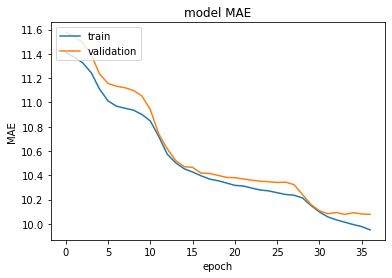

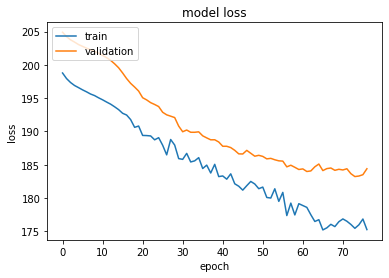

In [95]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(h2.history['mae'])
plt.plot(h2.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h3.history['loss'])
plt.plot(h3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Examine predictions

(array([139., 310., 245., 321., 317., 264., 262., 240., 221.,  93.]),
 array([-5.690571  , -3.7584178 , -1.826265  ,  0.10588799,  2.0380409 ,
         3.9701939 ,  5.9023466 ,  7.8345    ,  9.766653  , 11.698806  ,
        13.630959  ], dtype=float32),
 <a list of 10 Patch objects>)

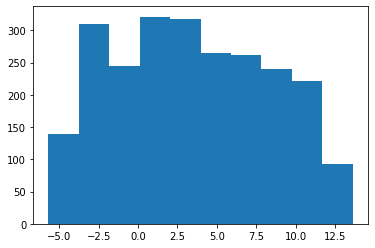

In [96]:
y_pred = m2.predict([X_home, X_away])
plt.hist(y_pred)

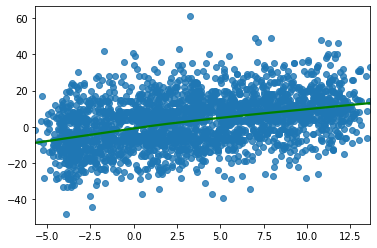

In [104]:
import seaborn as sns

sns.regplot(x=y_pred, y=y, lowess=True, line_kws={'color':'green'})